In [612]:
import gym
import minihack 
from nle import nethack 

import numpy as np 
import random
import matplotlib.pyplot as plt 
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import flatten

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

In [613]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model methods 

In [614]:
def display_screen(state):
    screen = Image.fromarray(np.uint8(state['pixel']))
    display(screen)

In [615]:
def compute_returns(rewards, gamma):
    returns = []
    r= 0
    for reward in rewards[::-1]:
        r = reward + gamma*r
        returns.append(r)
    returns.reverse()
    returns = np.array(returns)
    
    if np.mean(returns)!= 0:
         returns = returns - np.mean(returns)
        
    if np.std(returns) != 0:
        returns = returns/ np.std(returns)

    return returns

In [616]:
class ActorCritic(nn.Module):
    def __init__(self,s_size=8,h_size=128, a_size=4):
        
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.relu1= nn.ReLU()
        
        # To estimate the value function of the state 
        self.value_layer = nn.Linear(h_size, 1)
        
        # To calculate the probability of each action
        self.action_layer = nn.Linear(h_size, a_size)
        
        self.softmax = nn.Softmax(dim=-1)
        
        #self.logprobs = []
        #self.state_values = []
        #self.rewards = []

    def forward(self, state):
        
        state = self.fc1(state)
        state = self.relu1(state)
        
        state_value = self.value_layer(state)
        
        action_probs = self.action_layer(state)
        action_probs = self.softmax(action_probs)
        
        return action_probs,state_value

In [617]:
class ActorCritic(nn.Module):
    def __init__(self,s_size=8,h_size=128, a_size=4):
        super(ActorCritic, self).__init__()
        # initialize first set of CONV => RELU => POOL layers
        self.conv1 = Conv2d(in_channels=1, out_channels=20,
            kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = Conv2d(in_channels=20, out_channels=50,
            kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = Linear(in_features=1600, out_features=500)
        self.relu3 = ReLU()
        # initialize our softmax classifier
        self.fc2 = Linear(in_features=500, out_features=h_size)

        
        # To estimate the value function of the state 
        self.value_layer = nn.Linear(h_size, 1)

        # To calculate the probability of each action
        self.action_layer = nn.Linear(h_size, a_size)

        self.softmax = nn.Softmax(dim=-1)
        
        
        #self.logprobs = []
        #self.state_values = []
        #self.rewards = []

    def forward(self, state):
        
        x  = torch.from_numpy(state).float().to(device)

        # pass the input through our first set of CONV => RELU =>
        # POOL layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu3(x)
        # pass the output to our softmax classifier to get our output
        # predictions
        x = self.fc2(x)

        state_value = self.value_layer(x)
        
        action_probs = self.action_layer(x)
        action_probs = self.softmax(action_probs)
        
        return action_probs,state_value

In [646]:
def actor_critic(env, model, seed, learning_rate,betas, number_episodes, max_episode_length, gamma, max_reward, verbose=True):
    # set random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.seed(seed)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,betas=betas)
    scores =[]
    
    for i in range(number_episodes):
        # Reset environment
        state = format_state(env.reset())
        # Flag to see if episode has terminated
        done = False
        
        rewards = []
        log_probs = []
        state_values = []
        
        for t in range(1, max_episode_length):
            action_probs,state_value = model.forward(state)
            
            distribution = torch.distributions.Categorical(action_probs)
            action = distribution.sample()
            next_state, reward, done, _ = env.step(action.item())
            next_state = format_state(next_state)
    
            rewards.append(reward)
            log_probs.append(distribution.log_prob(action))
            state_values.append(state_value)
            
            state = next_state
            
            if done:
                break
        
        scores.append(np.sum(rewards))
        returns = compute_returns(rewards, gamma)
        returns = torch.from_numpy(returns).float().to(device)
        print("Episode:",i,"Average Reward:",np.mean(scores[-100:]))
        if np.mean(scores[-100:])>= max_reward:
            policy = model
            return policy, scores

        loss = 0
        for logprob, value, reward in zip(log_probs, state_values, returns):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            #value = value.resize(len(value),1)
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        
    policy = model

    return policy, scores

## Testing

In [647]:
NAVIGATE_ACTIONS = (
    nethack.CompassDirection.N,
    nethack.CompassDirection.E,
    nethack.CompassDirection.S,
    nethack.CompassDirection.W,)

In [648]:
def maze_explore_reward(env, prev_obs, action, next_obs):
    if (prev_obs[0] == 2359).sum() > (next_obs[0] == 2359).sum():
        return 0.1
    return 0

def standing_still(env, prev_obs, action, next_obs):
    if (prev_obs[13] == next_obs[13]).all():
        return -0.1
    return 0

In [649]:
from minihack import RewardManager
reward_gen = RewardManager()
reward_gen.add_eat_event("apple", reward=1)
reward_gen.add_custom_reward_fn(maze_explore_reward)
#reward_gen.add_custom_reward_fn(standing_still)

In [650]:
env = gym.make("MiniHack-MazeWalk-9x9-v0", observation_keys=["glyphs","pixel"], actions=NAVIGATE_ACTIONS, 
               max_episode_steps=10000)
              #reward_manager= reward_gen)

In [651]:
env.action_space.n

4

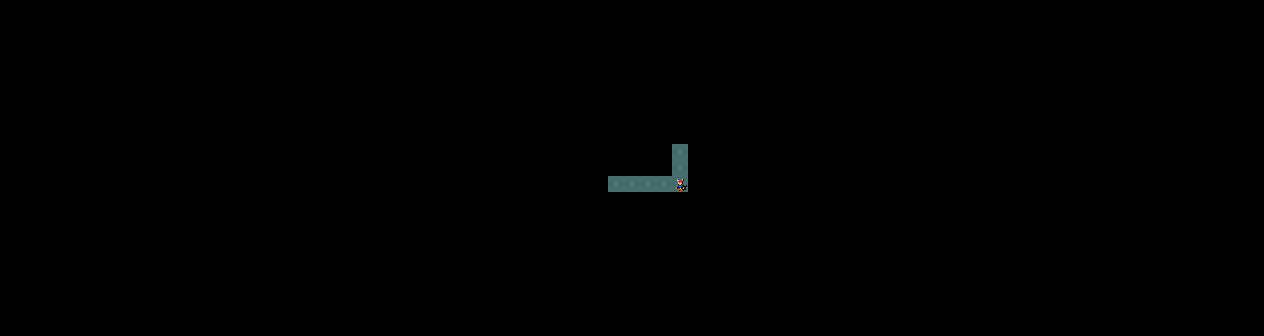

In [652]:
display_screen(env.reset())

In [653]:
def format_state(state):
    # Flatten the 2D array 
    #glyphs = state["glyphs"].flatten()
    glyphs = state["glyphs"]
    # Normalize
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    return glyphs

In [654]:
format_state(env.reset()).shape

(1, 1, 21, 79)

In [ ]:
model = ActorCritic(h_size=512, a_size=env.action_space.n)
policy, scores = actor_critic(env=env, model= model, seed=42, learning_rate=0.02, betas=(0.9, 0.999),
                           number_episodes=1500, max_episode_length=10000, gamma=0.99 ,verbose=True, max_reward=1)

Episode: 0 Reward -1.73 Average Reward: -1.73


/var/folders/wm/vfztc0rx29d3qrfj3k_2nkgm0000gn/T/ipykernel_90569/3403732991.py:52: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value, reward)


Episode: 1 Reward -99.97 Average Reward: -50.85
Episode: 2 Reward -99.97 Average Reward: -67.22333333333334
Episode: 3 Reward 0.91 Average Reward: -50.190000000000005
Episode: 4 Reward 0.64 Average Reward: -40.02400000000001
Episode: 5 Reward 0.1200000000000001 Average Reward: -33.333333333333336
Episode: 6 Reward -0.8800000000000001 Average Reward: -28.69714285714286
Episode: 7 Reward 0.83 Average Reward: -25.006249999999998
Episode: 8 Reward 0.019999999999999962 Average Reward: -22.22555555555555
Episode: 9 Reward -6.35 Average Reward: -20.637999999999998
Episode: 10 Reward -9.23 Average Reward: -19.600909090909088
Episode: 11 Reward -8.97 Average Reward: -18.714999999999996
Episode: 12 Reward -1.04 Average Reward: -17.35538461538461
Episode: 13 Reward 0.91 Average Reward: -16.05071428571428
Episode: 14 Reward 0.0699999999999999 Average Reward: -14.975999999999997
Episode: 15 Reward -10.82 Average Reward: -14.716249999999999
Episode: 16 Reward -0.33000000000000007 Average Reward: -13

Episode: 131 Reward -2.9900000000000007 Average Reward: -4.395700000000001
Episode: 132 Reward 0.77 Average Reward: -4.295000000000001
Episode: 133 Reward 0.6599999999999999 Average Reward: -3.2891000000000004
Episode: 134 Reward 0.71 Average Reward: -3.2163000000000004
Episode: 135 Reward -1.33 Average Reward: -3.2381
Episode: 136 Reward 0.6699999999999999 Average Reward: -3.1883
Episode: 137 Reward -0.29000000000000015 Average Reward: -3.2008000000000005
Episode: 138 Reward -12.33 Average Reward: -3.3148


In [ ]:
plt.plot(scores)

In [ ]:
model = ActorCritic(h_size=512, a_size=env.action_space.n)
policy, scores = actor_critic(env=env, model= model, seed=42, learning_rate=0.02, betas=(0.9, 0.999),
                           number_episodes=1500, max_episode_length=10000, gamma=0.99 ,verbose=True, max_reward=1)